# 重定义森林火灾模拟

在前面的例子中，我们定义了一个 `BurnableForest`，实现了一个循序渐进的生长和燃烧过程。

假设我们现在想要定义一个立即燃烧的过程（每次着火之后燃烧到不能燃烧为止，之后再生长，而不是每次只燃烧周围的一圈树木），由于燃烧过程不同，我们需要从 `BurnableForest` 中派生出两个新的子类 `SlowBurnForest`（原来的燃烧过程） 和 `InsantBurnForest`，为此

- 将 `BurnableForest` 中的 `burn_trees()` 方法改写，不做任何操作，直接 `pass`（因为在 `advance_one_step()` 中调用了它，所以不能直接去掉）
- 在两个子类中定义新的 `burn_trees()` 方法。

In [1]:
import numpy as np
from scipy.ndimage.measurements import label

class Forest(object):
    """ Forest can grow trees which eventually die."""
    def __init__(self, size=(150,150), p_sapling=0.0025):
        self.size = size
        self.trees = np.zeros(self.size, dtype=bool)
        self.p_sapling = p_sapling
        
    def __repr__(self):
        my_repr = "{}(size={})".format(self.__class__.__name__, self.size)
        return my_repr
    
    def __str__(self):
        return self.__class__.__name__
    
    @property
    def num_cells(self):
        """Number of cells available for growing trees"""
        return np.prod(self.size)
    
    @property
    def tree_fraction(self):
        """
        Fraction of trees
        """
        num_trees = self.trees.sum()
        return float(num_trees) / self.num_cells
    
    def _rand_bool(self, p):
        """
        Random boolean distributed according to p, less than p will be True
        """
        return np.random.uniform(size=self.trees.shape) < p
    
    def grow_trees(self):
        """
        Growing trees.
        """
        growth_sites = self._rand_bool(self.p_sapling)
        self.trees[growth_sites] = True    
        
    def advance_one_step(self):
        """
        Advance one step
        """
        self.grow_trees()

class BurnableForest(Forest):
    """
    Burnable forest support fires
    """    
    def __init__(self, p_lightning=5.0e-6, **kwargs):
        super(BurnableForest, self).__init__(**kwargs)
        self.p_lightning = p_lightning        
        self.fires = np.zeros((self.size), dtype=bool)
    
    def advance_one_step(self):
        """
        Advance one step
        """
        super(BurnableForest, self).advance_one_step()
        self.start_fires()
        self.burn_trees()
        
    @property
    def fire_fraction(self):
        """
        Fraction of fires
        """
        num_fires = self.fires.sum()
        return float(num_fires) / self.num_cells
    
    def start_fires(self):
        """
        Start of fire.
        """
        lightning_strikes = (self._rand_bool(self.p_lightning) & 
            self.trees)
        self.fires[lightning_strikes] = True
    
    def burn_trees(self):    
        pass
    
class SlowBurnForest(BurnableForest):
    def burn_trees(self):
        """
        Burn trees.
        """
        fires = np.zeros((self.size[0] + 2, self.size[1] + 2), dtype=bool)
        fires[1:-1, 1:-1] = self.fires
        north = fires[:-2, 1:-1]
        south = fires[2:, 1:-1]
        east = fires[1:-1, :-2]
        west = fires[1:-1, 2:]
        new_fires = (north | south | east | west) & self.trees
        self.trees[self.fires] = False
        self.fires = new_fires

class InstantBurnForest(BurnableForest):
    def burn_trees(self):
        # 起火点
        strikes = self.fires
        # 找到连通区域
        groves, num_groves = label(self.trees)
        fires = set(groves[strikes])
        self.fires.fill(False)
        # 将与着火点相连的区域都烧掉
        for fire in fires:
            self.fires[groves == fire] = True
        self.trees[self.fires] = False
        self.fires.fill(False)

测试：

In [2]:
forest = Forest()
sb_forest = SlowBurnForest()
ib_forest = InstantBurnForest()

forests = [forest, sb_forest, ib_forest]

tree_history = []

for i in xrange(1500):
    for fst in forests:
        fst.advance_one_step()
    tree_history.append(tuple(fst.tree_fraction for fst in forests))

显示结果：

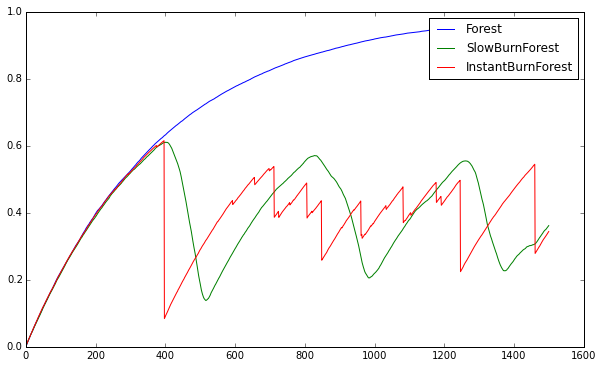

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

plt.plot(tree_history)
plt.legend([f.__str__() for f in forests])

plt.show()